In [1]:
try: 
    import pyedflib
except:
    !pip install pyedflib

In [3]:
import pyedflib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import warnings 
import random
import collections
from numpy.random import seed
import torch
import torch.utils as utils
import torch.utils.data as data
from os import path
import pandas as pd

c:\Users\TAACHUP2\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ','P7-T7','T7-FT9','FT9-FT10','FT10-T8']

#for i in range(23):
#file2 = pyedflib.EdfReader('chb12_06.edf')
#for channel in channels:
    #file2.readEdfFile(channel)
#signal_labels = file2.getSignalLabels()
#print(signal_labels)
#n = file2.signals_in_file
dat = readEdfFile('chb12_06.edf', channels)

print(dat.shape)

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
warnings.filterwarnings("ignore")
pathDataSet = 'CHB-MIT/'
processed_data_path = 'CHB-MIT_processed/'
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ','P7-T7','T7-FT9','FT9-FT10','FT10-T8']
patients = [ "01", "02"]
            #, "09", "10"]

In [8]:
def loadSummaryPatient(index):
  f = open(pathDataSet+'chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r') 
  parent = pathDataSet+'chb'+patients[index]+'/'
  return f, parent

In [9]:
def readEdfFile(pathToFile, channels):
    f = pyedflib.EdfReader(pathToFile)
    n = f.signals_in_file
    #print(n)
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((f.getNSamples()[0],n))
    for i in np.arange(n): 
        sigbufs[:,i] = f.readSignal(i)
    #sigbufs[:, n]= 0.0
    df =  pd.DataFrame(data = sigbufs, columns = signal_labels)
    #print(df.shape)
    df = df.loc[:, channels]
    #print(df.shape)
    df = df.loc[:, ~df.columns.duplicated()]
    #print(df.shape)
    f._close()
    del f
    data = df.values
    #data_numpy = data.to_numpy()
    return np.transpose(data)

In [33]:
#signal_label1 = ['2', '1']
signal_labels = ['3','4','2', '6','1']
#sigbufs = np.zeros((2,2))
sigbufs1 = np.zeros((3,5))
df =  pd.DataFrame(data = sigbufs1, columns = signal_labels)
df.iloc[:,4]=1
#print(df)
#df1 =  pd.DataFrame(data = sigbufs, columns = signal_label1)
cha = ['1','3']
#df1 = df1.loc[:, cha]
df = df.loc[:, cha]
print(df)

   1    3
0  1  0.0
1  1  0.0
2  1  0.0


In [16]:
def seizureNumpyMatrixGenerate(secSt, secEn, name_F, parent, index):
  file1 = pyedflib.EdfReader(parent+name_F)
  n = file1.signals_in_file
  rate =256
  col = file1.getNSamples()[0]
  # print(n)
  #signal_labels = file1.getSignalLabels()
  #signal_headers = file1.getSignalHeaders()
  #rate = signal_headers[0]['sample_rate']
  dur = file1.getFileDuration()
  #print(f'Duration of this trial {dur}')
  file1._close()
  del file1
  x = np.zeros((n, col))
  #for i in range(n):
    #x[i,:] = file1.readSignal(i)
  x = readEdfFile(parent+name_F, channels)
    # print(x)
    #label = file1.getLabel(i)
 
 
  #x_filter = butter_bandpass_filter(x ,lowcut , highcut , fs , order = 5)
  #a = os.getcwd()
  folder_path= processed_data_path + 'chb'+ patients[index] + '/'
  if os.path.isdir(processed_data_path) is not True:
    os.makedirs(processed_data_path)
  subfolder_path = folder_path + name_F.split('.')[0] + '/'
  if os.path.isdir(subfolder_path) is not True:
    os.makedirs(subfolder_path)
    print(subfolder_path)
    picnum = int(dur*rate/256)
    #print(picnum)
    num_seizure = 0
    num_nonseizure = 0
    for i in range(picnum):
      img = x[:,i*256:(i+1)*256]
      #img = (img - np.min(img))/(np.max(img) - np.min(img))
      #Img = Image.fromarray(np.uint8(img))
      if len(secSt) == 1:
        if secSt[0] <= i+1 <= secEn[0]: #window size is 1sec
            name = 'seizure'
            num_seizure+=1
        else:
            name = 'nonseizure'
            num_nonseizure +=1
      elif len(secSt) == 2:
        if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1]: #window size is 1sec
            name = 'seizure'
            num_seizure+=1
        else:
            name = 'nonseizure' 
            num_nonseizure +=1
      elif len(secSt) == 3:
        if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1] or secSt[2] <= i+1 <= secEn[2]: #window size is 1sec
            name = 'seizure'
            num_seizure+=1
        else:
            name = 'nonseizure'
            num_nonseizure +=1
      else: 
        if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1] or secSt[2] <= i+1 <= secEn[2] or secSt[3] <= i+1 <= secEn[3]:
            name = 'seizure'
            num_seizure+=1
        else:
            name = 'nonseizure'
            num_nonseizure +=1
          

      if i+1 < 10:
          filename = 'time_'+name+'_0000'+ str(i+1)
      elif 10 <= i+1 < 100:
          filename = 'time_'+name+'_000'+ str(i+1)
      elif 100 <= i+1 < 1000:
          filename = 'time_'+name+'_00'+ str(i+1)
      elif 1000 <= i+1 < 10000:
          filename = 'time_'+name+'_0'+ str(i+1)
      else:
          filename = 'time_'+name+'_'+ str(i+1)
      if path.exists(subfolder_path+ filename+'.npy'):
        continue
      else:
        np.save(subfolder_path + filename+'.npy', img)
          #print('-')
      
  else:
    print('folder already exists') 

  return (num_seizure, num_nonseizure, num_seizure+num_nonseizure, dur)

In [12]:
def createDataset():
    
    seizure_trials = {}
    total_duration = 0
    total_seizure = []
    total_nonseizure = []
    print("START \n")
    for indexPatient in range(0, len(patients)):
        seizure_num_per_patient = []
        nonseizure_num_per_patient = []
        values = []
        key = 'chb'+patients[indexPatient]
        #print(indexPatient)
        f, parent = loadSummaryPatient(indexPatient)
        line=f.readline()
        #print(' i was here')
        
        while (line):
            data=line.split(':')
            #print(data)
            if (data[0]=="File Name"):
                name_F=data[1].strip()
                
                #print(name_F)
                fileSt=f.readline().split(': ')[1]
                # Sthr=fileSt.split(':')[0]
                # #print(Sthr)
                # Stmin=fileSt.split(':')[1]
                # #print(Stmin)
                # Stsec=fileSt.split(':')[2]
                # #print(Stsec)
                fileEn=f.readline().split(': ')[1]
                # Enhr=fileEn.split(':')[0]
                # #print(Enhr)
                # Enmin=fileSt.split(':')[1]
                # #print(Enmin)
                # Ensec=fileSt.split(':')[2]
                # #print(Ensec)
                # trial_duration = ((int(Enhr) - int(Sthr))*3600 + (int(Enmin) - int(Stmin))*60 + (int(Ensec) - int(Stsec)))
                
                # print(trial_duration)
                for i in range(1):
                    line=f.readline()
                secSt = []
                secEn = []
                for j in range(0, int(line.split(': ')[1])):
                    if j==0:
                        print(f'trial : {name_F}')
                        value = name_F
                        values.append(value)
                                     
                    secSt.append(int(f.readline().split(': ')[1].split(' ')[0]))
                    #print(f'Start second of seizure {secSt}')
                    secEn.append(int(f.readline().split(': ')[1].split(' ')[0]))
                    #print(f'Start second of seizure {secEn}')
                if int(line.split(': ')[1]) != 0:
                    seizure_num_per_trial, nonseizure_num_per_trial, total_samples, dur = seizureNumpyMatrixGenerate(secSt, secEn, name_F, parent, indexPatient)   # creates numpy matrices for 1 s windows
                    total_duration += dur
                    print(f'No. of seizure samples : {seizure_num_per_trial}, No. of non-seizure samples : {nonseizure_num_per_trial}, Total no. of samples : {seizure_num_per_trial + nonseizure_num_per_trial}')
                    #seizure_num_per_trial.append(num_seizure)
                    #print(seizure_num_per_trial)
                    #nonseizure_num_per_trial.append(num_nonseizure)
                    #print(nonseizure_num_per_trial)
                    seizure_num_per_patient.append(seizure_num_per_trial)
                    nonseizure_num_per_patient.append(nonseizure_num_per_trial)
            seizure_trials[key] = values
            line=f.readline()
        f.close()
        
        print(seizure_num_per_patient)
        print(nonseizure_num_per_patient)
        total_seizure.append(np.sum(seizure_num_per_patient))
        print(total_seizure)
        total_nonseizure.append(np.sum(nonseizure_num_per_patient))
        print(total_nonseizure)
    
    print("END \n")
    return seizure_trials, total_duration, np.sum(total_seizure), np.sum(total_nonseizure)

In [17]:
seizure_trials, total_duration, total_duration_seizure, total_duration_nonseizure = createDataset()

START 

trial : chb01_03.edf
CHB-MIT_processed/chb01/chb01_03/
No. of seizure samples : 41, No. of non-seizure samples : 3559, Total no. of samples : 3600
trial : chb01_04.edf
CHB-MIT_processed/chb01/chb01_04/
No. of seizure samples : 28, No. of non-seizure samples : 3572, Total no. of samples : 3600
trial : chb01_15.edf
CHB-MIT_processed/chb01/chb01_15/
No. of seizure samples : 41, No. of non-seizure samples : 3559, Total no. of samples : 3600
trial : chb01_16.edf
CHB-MIT_processed/chb01/chb01_16/
No. of seizure samples : 52, No. of non-seizure samples : 3548, Total no. of samples : 3600
trial : chb01_18.edf
CHB-MIT_processed/chb01/chb01_18/
No. of seizure samples : 91, No. of non-seizure samples : 3509, Total no. of samples : 3600
trial : chb01_21.edf
CHB-MIT_processed/chb01/chb01_21/
No. of seizure samples : 94, No. of non-seizure samples : 3506, Total no. of samples : 3600
trial : chb01_26.edf
CHB-MIT_processed/chb01/chb01_26/
No. of seizure samples : 102, No. of non-seizure sample

In [18]:
print(seizure_trials,len(seizure_trials), total_duration, total_duration_seizure, total_duration_nonseizure)

{'chb01': ['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf'], 'chb02': ['chb02_16.edf', 'chb02_16+.edf', 'chb02_19.edf']} 2 32084 624 31460


In [12]:
seizure_trials = [ 'chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb02_16+.edf', 'chb02_19.edf', 'chb07_12.edf', 'chb07_13.edf', 'chb07_19.edf', 'chb08_02.edf', 'chb08_05.edf', 'chb08_11.edf', 'chb08_13.edf', 'chb08_21.edf']

In [19]:
def last_4chars(x): #function to sort the numbers in filename so that they can be grouped sequentially
  #print(x[-4])
  return(x[-4])

In [20]:
def create_feature_matrix(seizure_trials, folder_path, window_size, total_duration):
  features = np.zeros(((int(total_duration/window_size)),22,256*window_size))
  labels = np.zeros((int(total_duration/window_size)),dtype=int)
  i = 0 #the feature index
 
  for trial in seizure_trials:
      name = sorted(os.listdir(folder_path + trial.split('.')[0]), key= last_4chars)
      #print(name)
      #for window in (range(0, int(total_duration/len(seizure_trials)), window_size)):
      for window in (range(0, int(len(name)/window_size), window_size)):
          #print(window)
          seizure = 0
          non_seizure = 0
          feature_prep = np.zeros((22,256*window_size))
          for j in range(window_size):
              if '_seizure_' in name[window+j]:
                  #print(name[window+j])
                  seizure+=1
                  #print('seizure no.', seizure)
                  #print('hi')
                  feature_prep[0:22,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[window+j]))[0:22,0:256]
              elif '_nonseizure_' in name[window+j]:
                  #print(name[window+j])
                  non_seizure+=1
                  #print('nonseizure no.', non_seizure)
                  #print('nohi')
                  feature_prep[0:22,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[window+j]))[0:22,0:256]
                  #print(feature_prep.shape)
          #print(feature_prep.shape)
          feature_prep_normalized = (feature_prep - np.min(feature_prep)) / (np.max(feature_prep) -np.min(feature_prep))
          #print('seizure no.', seizure)
          #print('nonseizure no.', non_seizure)
          if seizure > non_seizure:
              #print('label should be 1')
              features[i] = feature_prep_normalized
              labels[i] = 1
              #print(features[i])
              #print(labels[i])
          else:
              #print('label should be 0')
              features[i] = feature_prep_normalized
              labels[i] = 0
              #print(features[i])
              #print(labels[i])
          #print('================================')
          i = i+1
         # print(features)
         # print(features.shape)
          
   #       print(i)
                  

  #print(i)
    #print(features)
    #print(labels)
    #print(np.expand_dims(np.array(features), axis=3).shape)
    #print(labels.shape)
  with open('features_train_1_2.npy', 'wb') as f:
    np.save(f, features)
  f.close
  
  with open('labels_train_1_2.npy', 'wb') as f:
    np.save(f, labels)
  f.close
  
  #dataloader = utils.data.DataLoader(dataset)
    #dataset = np.stack((features,labels), axis = 0)
  #print(dataset.shape)

  return 


In [25]:
seizure_trials_train = seizure_trials                 
for index in range(len(seizure_trials)):
#total_duration = 3600*len(seizure_trials_train)
    key_value_pair = list(seizure_trials_train.items())[index]
    print(key_value_pair[1])

['chb04_05.edf', 'chb04_08.edf', 'chb04_28.edf']
['chb05_06.edf', 'chb05_13.edf', 'chb05_16.edf', 'chb05_17.edf', 'chb05_22.edf']


In [53]:
#seizure_trials_train = ['chb08_02.edf', 'chb08_05.edf', 'chb08_11.edf', 'chb08_13.edf']
                  #, 'chb08_21.edf']
seizure_trials_train = seizure_trials                 
window_size = [1,2,4,8,10]
#index = 0
for index in range(len(seizure_trials)):
#total_duration = 3600*len(seizure_trials_train)
    folder_path= processed_data_path + 'chb'+ patients[index] + '/'
    key_value_pair = list(seizure_trials_train.items())[index]
    create_feature_matrix(key_value_pair[1], folder_path, window_size[2], total_duration)


In [60]:
seizure_trials_test = seizure_trials_train[-1]
print(seizure_trials_test)
window_size = [1,2,4,8,10]
index = 0
total_duration = 3600*len(seizure_trials_test)
folder_path= processed_data_path + 'chb'+ patients[index] + '/'
create_feature_matrix(seizure_trials, folder_path, window_size[2], total_duration)


chb08_13.edf


IndexError: list index out of range

In [21]:
features_train = np.load('features_train_1_2.npy')
labels_train = np.load('labels_train_1_2.npy')

print('features shape ', features_train.shape)
    # print('feature 0', features[0])
print('labels shape', labels_train.shape)
  #for i in range(len(labels)):
    #print(labels[i])

feature_tensor = torch.Tensor(features_train)
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(labels_train)

dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

features shape  (8021, 22, 1024)
labels shape (8021,)
features tensorshape  torch.Size([8021, 1, 22, 1024])


In [49]:
features_test = np.load('features_test.npy')
labels_test = np.load('labels_test.npy')

print('features shape ', features_test.shape)
    # print('feature 0', features[0])
print('labels shape', labels_test.shape)
  #for i in range(len(labels)):
    #print(labels[i])

feature_tensor = torch.Tensor(features_test)
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(labels_test)

test_dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

features shape  (900, 23, 1024)
labels shape (900,)
features tensorshape  torch.Size([900, 1, 23, 1024])


In [10]:
train_size = int(0.7*len(dataset))
val_size = int(0.2*len(dataset))
test_size = int(0.1*len(dataset))

In [11]:
#import numpy as np
#dataset = np.load(path+'preprocessed_data')
#train_dataset, val_dataset, test_dataset = data.random_split(dataset,
                                               #[train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3150, 900, 450)

In [14]:
c_train = 0
for i in range(len(train_dataset)):
  _, label = train_dataset[i][0], train_dataset[i][1]
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  if label == 1.0:
    c_train +=1
    #print(f"Image label: {label}")
print(c_train)
  #print(f"Label datatype: {type(label)}")

153


In [15]:
c_val = 0
for i in range(len(val_dataset)):
  _, label = val_dataset[i][0], val_dataset[i][1]
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  if label == 1.0:
    #print(f"Image label: {label}")
    c_val +=1
  #print(f"Label datatype: {type(label)}")
print(c_val)

45


In [16]:
c_test = 0
for i in range(len(test_dataset)):
  _, label = test_dataset[i][0], test_dataset[i][1]
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  if label == 1.0:
    c_test +=1
   # print(f"Image label: {label}")
print(c_test)
  #print(f"Label datatype: {type(label)}")

33


# Weighted Random Sampler


In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler
class_samples_count = [13745, 655]
weight = [1/ class_samples_count[0], 1/class_samples_count[1]]
#weight[0] = float(1/13745)
#weight[1] = float(1/655)
#samples_weight = [1/13745, 1/655]
#samples_weight = [1, 100]
samples_weight = np.array([weight[t] for t in range(2)])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
#print(samples_weight)
sampler_train = WeightedRandomSampler(weights = samples_weight, num_samples = len(train_dataset), replacement=True)

sampler_val = WeightedRandomSampler(samples_weight, len(val_dataset), replacement=True)

# Dataloader


# MyDataLoader


In [26]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     #sampler = sampler_train,
                                     batch_size=32, # how many samples per batch?
                                     num_workers=4, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, # use custom created test Dataset
                                    #sampler = sampler_val,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False) # don't usually need to shuffle testing data

test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    #sampler = sampler,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False) # don't usually need to shuffle testing data


train_dataloader, val_dataloader, test_dataloader

# Get image and label from custom DataLoader

# for i in range(len(train_dataloader)):
#   img_custom_val, label_val = next(iter(train_dataloader))
#   #print(img_custom_val.shape)
#   if label_val.any == 1.0:
#     print(label_val)


# 2D CNN


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

x = torch.randn(3,1,22,1024).to(device)
#print(x.shape)

class CNN(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,8), stride = (1,1), padding = 'same')
        self.pool1 = nn.MaxPool2d(kernel_size=(1,8), stride=(1,8))
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(1,16), stride = (1,1), padding = 'same')
        self.pool2 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,8), stride = (1,1), padding = 'same')
        self.pool3 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4))
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(16,1), stride = (1,1), padding = 'same')
        self.pool4 = nn.MaxPool2d(kernel_size=(4,1), stride=(4,1))
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(16,1), stride = (1,1), padding = 'same')
        self.pool5 = nn.MaxPool2d(kernel_size=(4,1), stride=(4,1))
        self.pool6 = nn.AvgPool2d(kernel_size=(1,int(size/128)), stride=(1,int(size/128)))
        self.fcn = nn.Linear(16, 2)
        #self.sigmoid=nn.Sigmoid()
    
    def forward(self,x):
        x=F.relu(self.conv1(x))
        #print('conv1 and relu', x.shape)
        x= self.pool1(x)
        #print('pool1', x.shape)
        x=F.relu(self.conv2(x))
        #print('conv2 and relu',x.shape)
        x= self.pool2(x)
        #print('pool2', x.shape)
        x=F.relu(self.conv3(x))
        #print('conv3 and relu', x.shape)
        x= self.pool3(x)
        #print('pool3', x.shape)
        x=F.relu(self.conv4(x))
        #print('conv4 and relu', x.shape)
        x= self.pool4(x)
        #print('pool4', x.shape)
        x=F.relu(self.conv5(x))
        #print('conv5 and relu', x.shape)
        x= self.pool5(x)
        #print('pool5', x.shape)
        x= self.pool6(x)
        #print('global avg pooling', x.shape)
        x = torch.squeeze(x,2)
        #print('1st squeezed x', x.shape)
        x = torch.squeeze(x,2)
        #print('2nd squeezed x', x.shape)
        x= self.fcn(x)
        #print('fcn', x.shape)
        #x= self.sigmoid(x)
        #print('final prediction', x.shape)
        return x
    
torch.manual_seed(42)
#model_1 = CNN(256).to(device)
#model_2 = CNN(512).to(device)
model = CNN(1024).to(device)
output = model(x.to(device))
print(model)
print(output.shape)
#output = model(img_custom_test.to(device))
#print(output)

CNN(
  (conv1): Conv2d(1, 4, kernel_size=(1, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(1, 16), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(1, 8), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=same)
  (pool5): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (pool6): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (fcn): Linear(in_features=16, out_features=2, bias=True)
)
torch.Size([

In [29]:
try: 
    import torchmetrics
except:
    !pip install torchmetrics 
    import torchmetrics

     -------------------------------------- 529.7/529.7 kB 4.8 MB/s eta 0:00:00


In [23]:
import torch
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):

    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc, train_avg_loss, train_avg_acc = 0, 0, 0, 0, 
    
    # Loop through data loader data batches
    for batch, (X_train, y_train) in enumerate(dataloader):
        # Send data to target device
        X_train = X_train.to(device)
        #print(X_train.shape)
        y_train = y_train.type(torch.LongTensor) 
        y_train = y_train.to(device)
        #print(y_train.shape)

        # 1. Forward pass
        y_logits_train = model(X_train)
        #print(y_logits_train.shape)
        y_prob_train = torch.softmax(y_logits_train, dim=1)
        #print(y_logits_train.shape)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_prob_train, y_train)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_train = torch.argmax(torch.softmax(y_logits_train, dim=1), dim=1)
        train_acc += (y_pred_train == y_train).sum().item()/len(y_logits_train)

        # Calculate and accumulate specificity
        # specificity = Specificity(average='micro', num_classes=2).to(device)
        # train_spec += specificity(y_pred_train, y_train)

    # Adjust metrics to get average loss and accuracy per batch 
    train_avg_loss = train_loss / len(dataloader)
    train_avg_acc = train_acc / len(dataloader)
    #train_avg_spec = train_spec / len(dataloader)
    return train_avg_loss, train_avg_acc

In [24]:
def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):

    # Put model in eval mode
    model.eval() 
    y_true = []
    y_pred = []
    # Setup test loss and test accuracy values
    val_loss, val_acc, val_avg_loss, val_avg_acc = 0, 0, 0, 0
    # for i in range(len(dataloader)):
    #     _, label_val = next(iter(dataloader))
    #     print(label_val)
    #print(dataloader.shape)
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X_val, y_val) in enumerate(dataloader):
            # Send data to target device
            X_val = X_val.to(device)
            #print('shape of x_val', X_val.shape)
            y_val = y_val.type(torch.LongTensor) 
            y_val = y_val.to(device)
            y_true.append(y_val)
            # 1. Forward pass
            y_logits_val = model(X_val)
            #print('y_val shape',y_val.shape)
            #print('y_val_logits shape', y_logits_val.shape)
            y_prob_val = torch.softmax(y_logits_val, dim=1)
            #print('y_val_softmax shape', y_prob_val.shape)
            # 2. Calculate and accumulate loss
            loss = loss_fn(y_prob_val, y_val)
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            y_pred_val = torch.argmax(torch.softmax(y_logits_val, dim=1), dim=1)
            val_acc += ((y_pred_val == y_val).sum().item()/len(y_logits_val))
            y_pred.append(y_pred_val)
            # Calculate and accumulate specificity
            # specificity = Specificity(average='micro', num_classes=2).to(device)
            # val_spec += specificity(y_pred_val, y_val)   
            
    # Adjust metrics to get average loss and accuracy per batch 
    val_avg_loss = val_loss / len(dataloader)
    val_avg_acc = val_acc / len(dataloader)
    # val_avg_spec = val_spec / len(dataloader)
    return val_avg_loss, val_avg_acc, y_true, y_pred

In [58]:
 m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
print(input, input.shape)
target = torch.empty(3).random_(2)
print(target, target.shape)
output = loss(m(input), target)
print(m(input), (m(input)).shape)


tensor([-0.2399,  1.2119, -0.4352], requires_grad=True) torch.Size([3])
tensor([1., 1., 1.]) torch.Size([3])
tensor([0.4403, 0.7706, 0.3929], grad_fn=<SigmoidBackward0>) torch.Size([3])


In [25]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0,23.0])),
          epochs: int = 10):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "train_spec": [],
        "val_loss": [],
        "val_acc": [],
        "val_spec": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_avg_loss, train_avg_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        val_avg_loss, val_avg_acc, y_true, y_pred = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_avg_loss:.4f} | "
            f"train_acc: {train_avg_acc:.4f} | "
           # f"train_spec: {train_avg_spec:.4f} "
            f"val_loss: {val_avg_loss:.4f} | "
            f"val_acc: {val_avg_acc:.4f} |"
         #   f"val_spec: {val_avg_spec:.4f} "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_avg_loss)
        results["train_acc"].append(train_avg_acc)
     #   results["train_spec"].append(train_avg_spec)
        results["val_loss"].append(val_avg_loss)
        results["val_acc"].append(val_avg_acc)
     #   results["val_spec"].append(val_avg_spec)

    # 6. Return the filled results at the end of the epochs
    return results

In [26]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
batch_size = 32
NUM_EPOCHS = 10
foldperf={}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = CNN(1024).to(device)
    #weight = torch.FloatTensor([1.0,23.0])
    #weight = torch.FloatTensor([total_duration_seizure/total_duration, total_duration_nonseizure/total_duration])
    weight = torch.FloatTensor([1/total_duration_nonseizure, 1/total_duration_seizure])
    #weight = weight.type(torch.LongTensor)
    weight = weight.to(device)
    # Setup loss function and optimizer
    #loss_fn = nn.BCELoss(weight = weight)
    loss_fn = nn.CrossEntropyLoss(weight = weight)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    #, betas=(0.9, 0.999))

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Train model_0 
    model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    foldperf['fold{}'.format(fold+1)] = model_results  

torch.save(model,'k_cross_CNN2D_4_5.pt')    


Fold 1
Epoch: 1 | train_loss: 0.3574 | train_acc: 0.9338 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 2 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 3 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 4 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 5 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 6 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 7 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 8 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 9 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Epoch: 10 | train_loss: 0.3133 | train_acc: 1.0000 | val_loss: 0.3133 | val_acc: 1.0000 |
Total training time: 18.225 seconds
Fold 2
Epoch: 1 | train_loss: 0.3432 | train_acc: 1.0000 | val_los

In [ ]:
test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    #sampler = sampler,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False)

test_loss, test_acc, test_spec = val_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
print(
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f} | "
      f"test_spec: {test_spec:.4f} ")

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

'''
TP : the number of segments that are correctly identified as ictal (x_true == x_pred == 1)
TN : the number of EEG segments that are correctly classified as non-ictal (x_true == x_pred == 0)
FP : the number of EEG segments that are incorrectly classified as ictal (x_true == 0 && x_pred == 1)
FN : the segments that are incorrectly classified as non-ictal (x_true == 1 && x_pred == 0)
'''
def classificationPerformanceIndexes (true_arr, pred_arr):
    (tn, fp, fn, tp) = confusion_matrix(true_arr, pred_arr).ravel()
    acc = accuracy_score(true_arr, pred_arr)                           # Accuracy
    snv = tp/(tp + fn)                                                 # Sensitivity or True Positive Rate (TPR)
    spc = tn/(tn + fp)                                                 # Specificity or True Negative Rate (TNR)
    ppv = tp/(tp + fp)                                                 # Precision or Positive Predictive Value (PPV)
    f1 = f1_score(true_arr, pred_arr)                                  # F1 score
    #mcc = matthews_corrcoef(true_arr, pred_arr)                        # Matthews Correlation Coefficient
    #kappa = cohen_kappa_score(true_arr, pred_arr)                      # Cohen’s Kappa    
    return acc, snv, spc, ppv, f1

In [88]:
def printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1):
    #print('Method:', method)
    print('Accuracy:', acc)
    print('Sensitivity/Recall:', snv)
    print('Specificity:', spc)
    print('Precision:', ppv)
    print('F1 Score:', f1)
    #print('Matthews Correlation Coefficient:', mcc)
    #print('Cohen’s Kappa:', kappa)

In [ ]:
acc, snv, spc, ppv, f1 = classificationPerformanceIndexes(y_true, y_pred)
printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1)

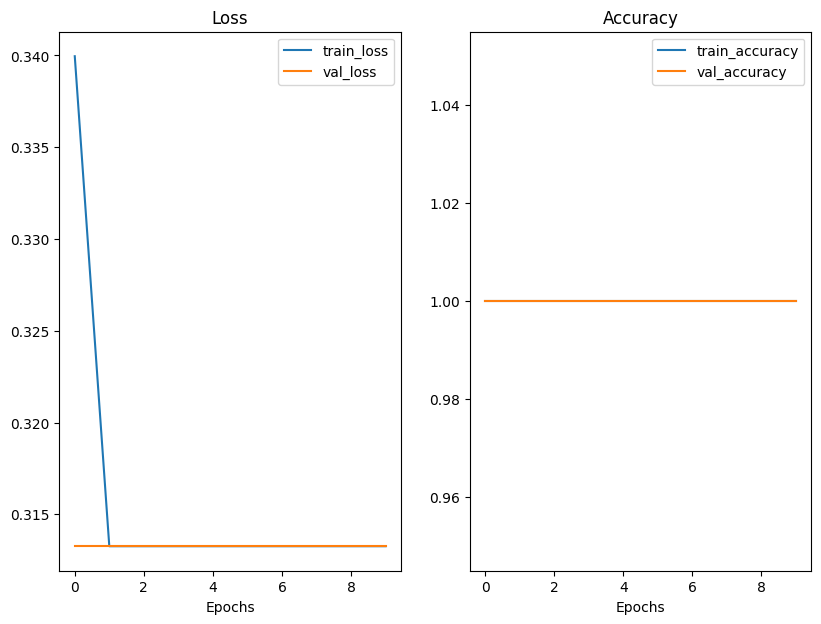

In [28]:
def plot_loss_curves(results):
  #: Dict[str, List[float]]
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    losses = results['train_loss']
    losses_array= [loss for loss in losses]
    #loss.detach().numpy()
    #print(losses)
    val_losses = results['val_loss']
    #val_losses_array= [loss.detach().numpy() for loss in val_losses]
    val_losses_array= [loss for loss in val_losses]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    #print(accuracy)
    val_accuracy = results['val_acc']

    # Get the specificity of the results dictionary (training and test)
    specificity = results['train_spec']
    specificity_array= [spec.cpu().numpy() for spec in specificity]
    #print(specificity_array)
    val_specificity = results['val_spec']
    val_specificity_array = [spec.cpu().numpy() for spec in val_specificity]
    #val_specificity_array = [spec for spec in val_specificity]

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    #print(type(epochs))
    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses_array, label='train_loss')
    plt.plot(epochs, val_losses_array, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot specificity
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, specificity_array, label='train_specificity')
    # plt.plot(epochs, val_specificity_array, label='val_specificity')
    # plt.title('Specificity')
    # plt.xlabel('Epochs')
    # plt.legend()

plot_loss_curves(model_results)
plt.savefig('model_results_with_class_weights_1_2.png')


In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model = CNN(1024).to(device)
weight = torch.FloatTensor([1.0,23.0])
#weight = weight.type(torch.LongTensor)
weight = weight.to(device)
# Setup loss function and optimizer
#loss_fn = nn.BCELoss(weight = weight)
loss_fn = nn.CrossEntropyLoss(weight = weight)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
#, betas=(0.9, 0.999))

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")